<a href="https://colab.research.google.com/github/giacomogreggio/computer-vision-project/blob/master/Carvana_image_masking_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import math
import numpy as np
from tensorflow import keras
import cv2
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, ZeroPadding2D, Cropping2D, Softmax, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
from PIL import Image

from IPython.display import clear_output
import matplotlib.pyplot as plt

**DATASET PREPROCESSING**

In [28]:
DATASET_PATH = '../a'
IMAGE_PATH = DATASET_PATH + '/img'
MASK_PATH = DATASET_PATH + '/mask'

In [52]:
IMAGE_SHAPE = (171, 256, 3)
N_CLASSES = 2
L2_VALUE = 5**-4

BATCH_SIZE = 20
EPOCHS = 100

TRAIN_LENGTH = len(os.listdir(IMAGE_PATH))
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [53]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image


def open_image(name, path):
    with open(path + '/' + name, 'rb') as f:
        return np.load(f) 

In [54]:
example_images = []
example_masks = []
NAMES = os.listdir(IMAGE_PATH)
number_of_examples = 10
for i, img_id in enumerate(NAMES):
    example_images.append(open_image(img_id, IMAGE_PATH))
    example_masks.append(open_image(img_id, MASK_PATH))
    
    if i==number_of_examples:
        break

In [99]:
def print_img(img):
    plt.figure(figsize=(14, 7))
    plt.subplot(1,1,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Lena'), plt.axis('off')
    
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    display_list[1] = np.expand_dims(display_list[1],axis=2)

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(num=1):
    for i in range(num if num < len(example_images) else len(example_images)):  
        n = len(example_images)-i-1
        pred_mask = create_mask(model(np.expand_dims(example_images[i],axis=0)))
        display([example_images[n], example_masks[n], pred_mask])

In [100]:
class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path, mask_path,
                 to_fit=True, batch_size=32, dim=(256, 256),
                 n_channels=1, n_classes=10, shuffle=True):
        self.list_IDs = list_IDs
        self.image_path=image_path
        self.mask_path=mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = open_image(ID, self.image_path)
        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            y[i] = open_image(ID, self.mask_path)
        return y

In [101]:
generator = DataGenerator(NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                 to_fit=True, batch_size=BATCH_SIZE, dim=(IMAGE_SHAPE[:2]),
                 n_channels=IMAGE_SHAPE[2], n_classes=N_CLASSES, shuffle=True)

**USEFUL METHODS**

In [102]:
def calculate_output_shape(input_layer, last_layer):
    return np.array(Model(input_layer, last_layer).layers[-1].output_shape[1:])

def calculate_crop_value(output_shape, size_to_crop):
    pixel_difference=output_shape-size_to_crop

    half_height_left=int(pixel_difference[0]/2)
    half_height_right=math.ceil(pixel_difference[0]/2)
    half_width_left=int(pixel_difference[1]/2)
    half_width_right=math.ceil(pixel_difference[1]/2)

    return tuple([tuple([half_height_left,half_height_right]),tuple([half_width_left,half_width_right])])

class Crop(tf.keras.layers.Layer):
    def call(self, inputs):
        x1, x2 = inputs
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return x1_crop

**VGG**

In [103]:
def create_base_vgg(trainable=True):
    #Defining Base VGG architecture
    input_layer = Input(shape=IMAGE_SHAPE, name="input")
    #VGG-block1
    b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_1")(input_layer)
    b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_2")(b1)
    b1 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b1")(b1)

    #VGG-block2
    b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_1")(b1)
    b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_2")(b2)
    b2 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b2")(b2)

    #VGG-block3
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_1")(b2)
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_2")(b3)
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_3")(b3)
    b3 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b3")(b3)

    #VGG-block4
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_1")(b3)
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_2")(b4)
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_3")(b4)
    b4 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b4")(b4)

    #VGG-block5
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_1")(b4)
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_2")(b5)
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_3")(b5)
    b5 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b5")(b5)

    vgg_model = Model(input_layer, b5)
    vgg16= VGG16(weights="imagenet", include_top=False)
    vgg16.save_weights("./weights.h5")
    vgg_model.load_weights("./weights.h5")
    vgg_model.trainable=trainable

    return vgg_model

**FCN-32**

In [104]:
def create_fcn32(vgg_trainable=True, include_top=True):
    vgg_model=create_base_vgg(trainable=vgg_trainable)
    b5=vgg_model.layers[-1].output
    input_layer=vgg_model.layers[0].output
    fcn_32_block = Conv2D(4096, kernel_size=(7,7), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_1")(b5)
    fcn_32_block = Dropout(0.5, name="dropout_fcn32_1")(fcn_32_block)
    fcn_32_block = Conv2D(4096, kernel_size=(1,1), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_2")(fcn_32_block)
    fcn_32_block = Dropout(0.5, name="dropout_fcn32_2")(fcn_32_block)
    fcn_32_block = Conv2D(N_CLASSES, kernel_size=(1,1), padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_3")(fcn_32_block)
    if include_top:
        fcn_32_transpose = Conv2DTranspose(N_CLASSES, kernel_size=(64,64), strides=(32,32), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn32")(fcn_32_block)
        fcn_32_crop = Crop([fcn_32_transpose, input_layer])
        fcn_32_softmax=Softmax(name="softmax_fcn32")(fcn_32_crop)
        return Model(input_layer, fcn_32_softmax)
    else:
        return Model(input_layer, fcn_32_block)

**FCN-16**

In [105]:
def create_fcn16(vgg_trainable=True, include_top=True):
    fcn_32=create_fcn32(vgg_trainable=vgg_trainable, include_top=False)
    input_layer=fcn_32.layers[0].output
    b4=fcn_32.get_layer("maxpool_b4").output
    fcn_32_block=fcn_32.layers[-1].output

    fcn_16_block_fcn32 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_1")(fcn_32_block)
    fcn_16_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn16_1")(b4)

    fcn_16_block_fcn32 = Crop()([fcn_16_block_fcn32,fcn_16_block])

    fcn_16_block = Add(name="add_fcn16")([fcn_16_block_fcn32,fcn_16_block])

    if include_top:
        fcn_16_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(32,32), strides=(16,16), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_2")(fcn_16_block)
        fcn_16_crop = Crop()([fcn_16_deconv,input_layer])
        fcn_16_softmax=Softmax(name="softmax_fcn16")(fcn_16_crop)
        return Model(input_layer, fcn_16_softmax)
    else:
        return Model(input_layer, fcn_16_block)

**FCN-8**

In [106]:
def create_fcn8(vgg_trainable=True, include_top=True):
    fcn_16=create_fcn16(vgg_trainable=vgg_trainable, include_top=False)
    input_layer=fcn_16.layers[0].output
    b3=fcn_16.get_layer("maxpool_b3").output
    fcn_16_block=fcn_16.layers[-1].output

    fcn_8_block_fcn16 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_1")(fcn_16_block)
    fcn_8_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn8_1")(b3)


    fcn_8_block_fcn16 = Crop()([fcn_8_block_fcn16,fcn_8_block])

    fcn_8_block = Add(name="add_fcn8")([fcn_8_block_fcn16,fcn_8_block])

    if include_top:
        fcn_8_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(16,16), strides=(8,8), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_2")(fcn_8_block)
        fcn_8_crop = Crop()([fcn_8_deconv,input_layer])
        fcn_8_softmax=Softmax(name="softmax_fcn8")(fcn_8_crop)
        return Model(input_layer, fcn_8_softmax)
    else:
        return Model(input_layer, fcn_8_block)

**CALLBACKS**

In [107]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [108]:
class print_lr(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Current Learning rate : {}".format(self.model.optimizer.lr.numpy()))

In [109]:
class AdaptedMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', N_CLASSES=3,**kwargs):
        super(AdaptedMeanIoU, self).__init__(name=name, **kwargs)
        self.mean_iou=MeanIoU(N_CLASSES)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_converted=tf.argmax(y_pred,axis=-1)
        self.mean_iou.update_state(y_true,y_pred_converted)
        
    def result(self):
        return self.mean_iou.result()
    
    def reset_states(self):
        self.mean_iou.reset_states()

In [110]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1**-10)

In [111]:
callbacks=[
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint("car_model.h5", save_best_only=True),
    DisplayCallback(),
    reduce_lr, 
    print_lr()
]

In [112]:
model=create_fcn8()
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, clipnorm=1), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(N_CLASSES=3)])
model.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 171, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_b1_1 (Conv2D)            (None, 171, 256, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_b1_2 (Conv2D)            (None, 171, 256, 64) 36928       conv2d_b1_1[0][0]                
__________________________________________________________________________________________________
maxpool_b1 (MaxPooling2D)       (None, 85, 128, 64)  0           conv2d_b1_2[0][0]                
______________________________________________________________________________________

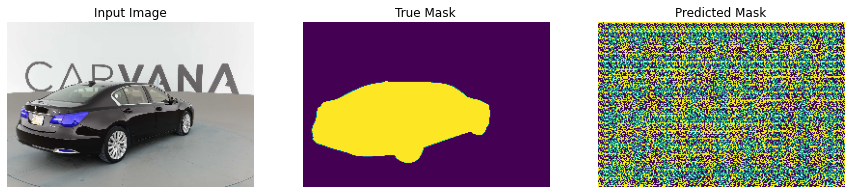

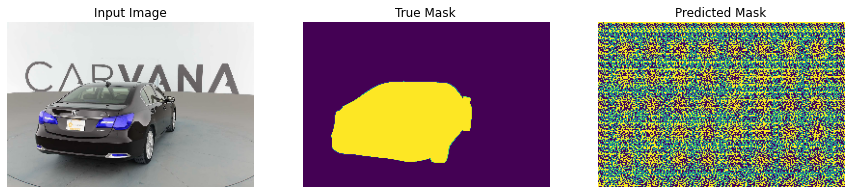

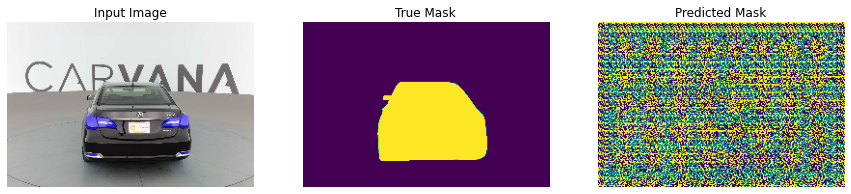

In [113]:
show_predictions(3)

In [114]:
model_history = model.fit(generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[DisplayCallback(),reduce_lr, print_lr()])

Current Learning rate : 0.10000000149011612
Epoch 1/100
  3/254 [..............................] - ETA: 55:16 - loss: 8.7647 - mean_iou: 0.3095

KeyboardInterrupt: 

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])